In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

import sys, glob
[sys.path.append(f) for f in glob.glob('../utils/*')]
from plotting_utils import figSize
from hmm import HMMRecalibration
import hmm_utils
import simulation_utils 
from simulation import simulateBCIFitts
import stabilizer_utils
from stabilizer_utils import Stabilizer

# for a reproducible result
np.random.seed(1)

fig_path    = '/home/users/ghwilson/projects/nonstationarities/figures/'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Define an initial decoder and initial neural tuning properties (mean firing rates and preferred directions).


In [4]:

def simulate_MultiSessionStretch(base_opts, ss_opts):
    
    cfg_dict   = dict()
    order_dict = {'norecal_cfg' : 0, 'supervised_cfg' : 1}
    cfg_dict['supervised_cfg'] = simulation_utils.initializeBCI(base_opts)
    cfg_dict['norecal_cfg']    = simulation_utils.initializeBCI(base_opts)
    
    cfg_dict['ss_naive_cfg'], naive_decoder_dict, naive_stabilizer = simulation_utils.initializeBCI({**base_opts, **ss_opts})
    cfg_dict['ss_naive_cfg']['neuralTuning'][:, 0] = 0
    order_dict['ss_naive_cfg'] = len(order_dict.keys())

    cfg_dict['ss_daisy_cfg'], daisy_decoder_dict, daisy_stabilizer = simulation_utils.initializeBCI({**base_opts, **ss_opts})
    cfg_dict['ss_daisy_cfg']['neuralTuning'][:, 0] = 0
    order_dict['ss_daisy_cfg'] = len(order_dict.keys())

    session_scores = np.zeros((base_opts['n_sessions'] + 1, len(cfg_dict.keys())))
        
    # Day 0 performance:
    D_dict = dict()
    for key, cfg in cfg_dict.items():
        D_key         = key.split('cfg')[0] + 'D'
        D_dict[D_key] = np.copy(cfg_dict[key]['D'])
        
    for i, (key, value) in enumerate(cfg_dict.items()):
        session_scores[0, order_dict[key]] = np.mean(simulateBCIFitts(value)['ttt'])

    
    for i in range(base_opts['n_sessions']):
        for j in range(base_opts['days_between'] + 1):
            for key, cfg in cfg_dict.items():
                # introduce daily nonstationarities between recorded sessions
                cfg['neuralTuning'] = simulation_utils.simulateTuningShift(cfg['neuralTuning'], n_stable = base_opts['n_stable'], PD_shrinkage = base_opts['shrinkage'], 
                                                                  mean_shift = 0, renormalize = simulation_utils.sampleSNR())  
        
        # No recalibration:
        D_dict['norecal_D'][:, 0] = D_dict['norecal_D'][:,0] / np.linalg.norm(D_dict['norecal_D'][1:, :][:, 0]) / np.linalg.norm(cfg_dict['norecal_cfg']['neuralTuning'][:, 1])
        D_dict['norecal_D'][:, 1] = D_dict['norecal_D'][:,1] / np.linalg.norm(D_dict['norecal_D'][1:, :][:, 1]) / np.linalg.norm(cfg_dict['norecal_cfg']['neuralTuning'][:, 2])        

        cfg_dict['norecal_cfg']['D']    = D_dict['norecal_D']
        cfg_dict['norecal_cfg']['beta'] = simulation_utils.gainSweep(cfg_dict['norecal_cfg'], possibleGain = base_opts['possibleGain'])
        
        idx                          = order_dict['norecal_cfg']
        session_scores[i+1, idx] = np.mean(simulateBCIFitts(cfg_dict['norecal_cfg'])['ttt'])
        
        # supervised: 
        cfg_dict['supervised_cfg']['D'] = simulation_utils.simulate_OpenLoopRecalibration(cfg_dict['supervised_cfg'], nSteps = 10000)
        cfg_dict['supervised_cfg']['D'] = simulation_utils.simulate_ClosedLoopRecalibration(cfg_dict['supervised_cfg'])
        idx                             = order_dict['supervised_cfg']
        
        cfg_dict['supervised_cfg']['beta'] = simulation_utils.gainSweep(cfg_dict['supervised_cfg'], possibleGain = base_opts['possibleGain'])
        session_scores[i+1, idx]        = np.mean(simulateBCIFitts(cfg_dict['supervised_cfg'])['ttt'])
        
        # Stabilizer (naive):   
        cfg_dict['ss_naive_cfg']['D']    = simulation_utils.simulate_LatentClosedLoopRecalibration(cfg_dict['ss_naive_cfg'], naive_decoder_dict, naive_stabilizer, ss_opts)
        cfg_dict['ss_naive_cfg']['beta'] = simulation_utils.gainSweep(cfg_dict['ss_naive_cfg'], possibleGain = base_opts['possibleGain'])

        idx                      = order_dict['ss_naive_cfg']
        session_scores[i+1, idx] = np.mean(simulateBCIFitts(cfg_dict['ss_naive_cfg'])['ttt'])       

        # stabilizer (daisy-chained):
        cfg_dict['ss_daisy_cfg']['D'] = simulation_utils.simulate_LatentClosedLoopRecalibration(cfg_dict['ss_daisy_cfg'], daisy_decoder_dict, daisy_stabilizer, 
                                                                                          ss_opts, daisy_chain = True)
        cfg_dict['ss_daisy_cfg']['beta'] = simulation_utils.gainSweep(cfg_dict['ss_daisy_cfg'], possibleGain = base_opts['possibleGain'])

        idx                      = order_dict['ss_daisy_cfg']
        session_scores[i+1, idx] = np.mean(simulateBCIFitts(cfg_dict['ss_daisy_cfg'])['ttt'])


    return session_scores
    
    
#TODO:
# - modify tuning to remove means (thats whats breaking subspace realignment here)
# - modify so each method gets its own initial tuning setup on day 0 and its own tuning shift 
#    - this will let you keep the independent samples t test 

In [5]:
import copy
from joblib import Parallel, delayed

np.random.seed(42)

# general settings:
reps  = 30   # how many times to repeat the repeated nonstationarities simulation


base_opts = dict()
base_opts['alpha']          = 0.94 # amount of exponential smoothing (0.9 to 0.96 are reasonable)
base_opts['delT']           = 0.02 # define the time step (20 ms)
base_opts['nDelaySteps']    = 10   # define the simulated user's visual feedback delay (200 ms)
base_opts['nSimSteps']      = 20000
base_opts['nUnits']         = 192
base_opts['SNR']            = 0.5
base_opts['possibleGain']   = np.linspace(0.1,2.5,10)
base_opts['center_means']   = True
base_opts['nTrainingSteps'] = 10000


base_opts['n_sessions']   = 30    # number of sessions to simulate 
base_opts['days_between'] = 0     # days between session days
base_opts['shrinkage']    = 0.91  # relative tuning in subspace per new day
base_opts['n_stable']     = 0

# stabilizer settings:
ss_opts                 = dict()
ss_opts['B']            = 190
ss_opts['thresh']       = 0.1
ss_opts['n_components'] = 6
ss_opts['model_type']   = 'PCA'


#-----------------------------------------
session_scores          = np.zeros((reps, base_opts['n_sessions'] + 1, 4)) 

args           = [[base_opts, ss_opts]] * reps
rep_data       = Parallel(n_jobs= -1, verbose = 11)(delayed(simulate_MultiSessionStretch)(*x) for x in args)
session_scores = np.dstack(rep_data).swapaxes(2, 0).swapaxes(1, 2)
    

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done   4 out of  30 | elapsed: 15.6min remaining: 101.5min
[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed: 15.6min remaining: 51.4min
[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed: 15.7min remaining: 31.3min
[Parallel(n_jobs=-1)]: Done  13 out of  30 | elapsed: 15.7min remaining: 20.5min
[Parallel(n_jobs=-1)]: Done  16 out of  30 | elapsed: 15.7min remaining: 13.7min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed: 15.7min remaining:  9.1min
[Parallel(n_jobs=-1)]: Done  22 out of  30 | elapsed: 15.8min remaining:  5.7min
[Parallel(n_jobs=-1)]: Done  25 out of  30 | elapsed: 15.8min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done  28 out of  30 | elapsed: 16.2min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 17.5min finished


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


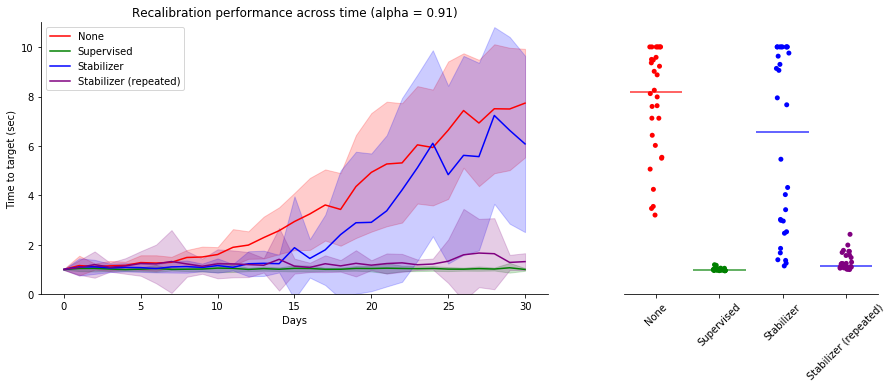

In [6]:
figSize(5, 15)
from lineplots import plotsd
import seaborn as sns 
figSize(5, 15)

labels = ['None', 'Supervised', 'Stabilizer', 'Stabilizer (repeated)']
colors = ['r', 'g', 'b', 'purple']


days     = np.linspace(0, (base_opts['days_between'] + 1) * base_opts['n_sessions'], base_opts['n_sessions'] + 1)
fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})

# plot data across time
plt.axes(axs[0])
for i, label in enumerate(labels):
    plotsd(data = session_scores[:, :, i], time_bins = days, color = colors[i], toggleSE = False)

axs[0].legend(labels, loc = 'upper left')
axs[0].set_title('Recalibration performance across time (alpha = ' + str(base_opts['shrinkage']) + ')')
axs[0].set_xlabel('Days')
axs[0].set_ylabel('Time to target (sec)')
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].set_ylim([0, 11])

# and now the results on final day
plt_data = [session_scores[:, -1, i].flatten() for i in range(len(labels))]
cmap     = dict(zip(np.arange(len(labels)), colors))
sns.stripplot(data = plt_data, palette = cmap, ax = axs[1])

sns.boxplot(medianprops={'ls': '-', 'lw': 2, 'alpha' : 0.6}, whiskerprops={'visible': False},
            zorder=1, data=plt_data, showfliers=False, showbox=False, showcaps=False, ax=axs[1])

for i, line in enumerate(axs[1].get_lines()):
    line.set_color(cmap[np.floor(i / len(colors))])

axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].set_yticks([])
axs[1].set_xticklabels(labels, rotation = 45)
axs[1].set_ylim([0, 11])


plt.savefig(fig_path + 'simulator/static_vs_daisychained_stabilizer', format = 'pdf')
plt.show()


In [8]:
import scipy

for i in range(len(labels)):
    for j in range(len(labels)):
        if j > i:
            print('{} and {}: \n'.format(labels[i], labels[j]), scipy.stats.ranksums(plt_data[i], plt_data[j]) )
            print('\n')

None and Supervised: 
 RanksumsResult(statistic=6.6529914385911555, pvalue=2.8719490663203234e-11)


None and Stabilizer: 
 RanksumsResult(statistic=1.4488736910709628, pvalue=0.14737285954906498)


None and Stabilizer (repeated): 
 RanksumsResult(statistic=6.6529914385911555, pvalue=2.8719490663203234e-11)


Supervised and Stabilizer: 
 RanksumsResult(statistic=-6.623422587752973, pvalue=3.5097576968084746e-11)


Supervised and Stabilizer (repeated): 
 RanksumsResult(statistic=-5.8842013167984, pvalue=3.999807467435263e-09)


Stabilizer and Stabilizer (repeated): 
 RanksumsResult(statistic=5.898985742217492, pvalue=3.6574283634182552e-09)


